In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE  # tf.data에서 파일을 핸들링 하는것을 최적화 해주는데 사용되는 API

# tensorflow 버전과 eager 모드, GPU 확인
print('버전:', tf.__version__)
print('즉시 실행 모드:',tf.executing_eagerly())
print('GPU:', '사용 가능' if tf.config.experimental.list_physical_devices('GPU') else '사용 불가능')

import cv2
import os
import IPython.display as display
import glob

버전: 2.5.0
즉시 실행 모드: True
GPU: 사용 가능


In [3]:
# Fashion mnist 데이터 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
# 데이터 크기 확인
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}\nx_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (60000, 28, 28), y_train: (60000,)
x_test: (10000, 28, 28), y_test: (10000,)


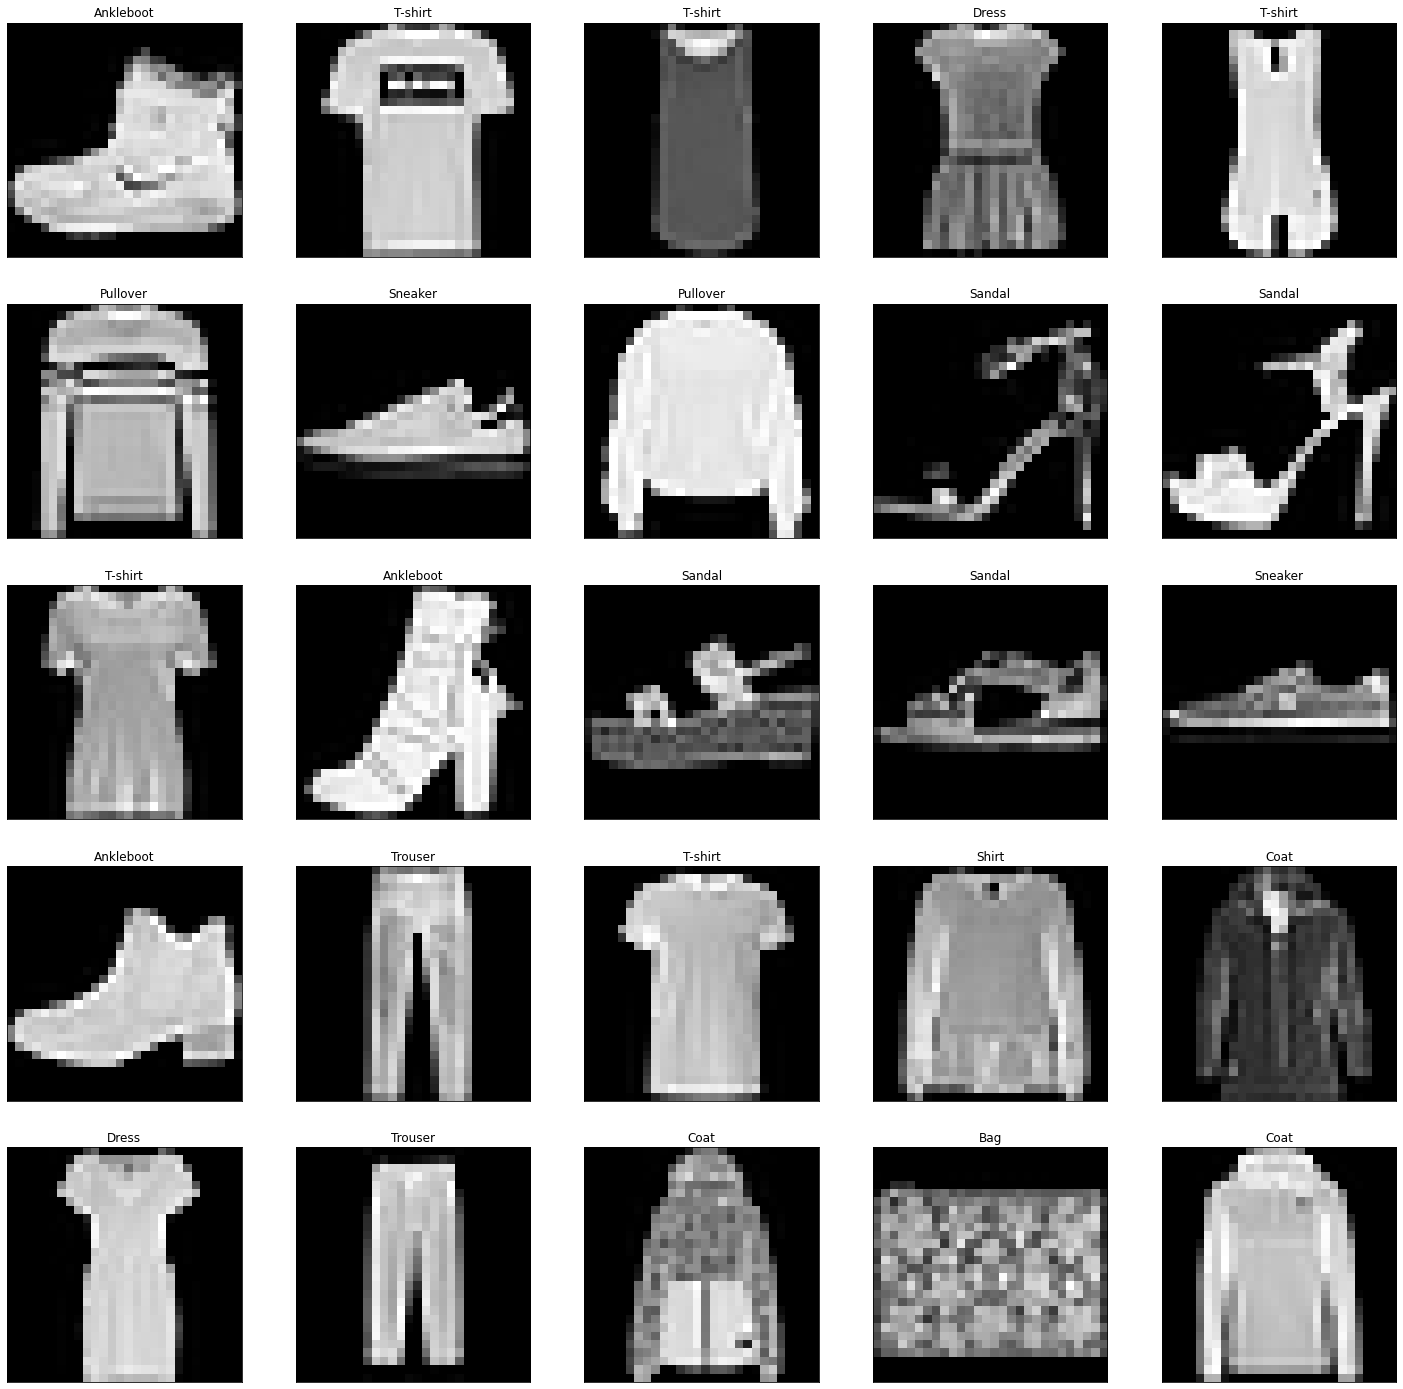

In [5]:
# 이미지 확인

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot']

fig = plt.figure(figsize=(25, 25))
axes = np.empty(shape=(0, ))
for row_idx in range(5):
    for col_idx in range(5):
        ax = fig.add_subplot(5, 5, row_idx*5 + col_idx + 1)
        ax.tick_params(bottom=False, labelbottom=False,
                       left=False, labelleft=False)
        axes = np.append(axes, ax)


for idx, ax in enumerate(axes):
    ax.imshow(x_train[idx], 'gray')
    ax.set_title(class_names[y_train[idx]])

In [6]:
# colab에서 드라이브 마운트 후에 진행
# 노트북 파일이 구글 드라이브의 ./Colab Notebooks/ 에 위치하는 상태에서 실행

train_path = './content/drive/My drive/Colab Notebooks/fmnist/train/'
test_path = './content/drive/My drive/Colab Notebooks/fmnist/test/'
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

In [7]:
# Train 이미지중 6000개만 jpg로 저장

i=0
for img,index in zip(x_train[:6000], y_train[:6000]):
    i += 1
    cv2.imwrite(f'{train_path}{i:05d}_{class_names[index]}.jpg', img)
    if i % 600 == 0:
        print(f'train 이미지 저장 진행중 {i}')

train 이미지 저장 진행중 600
train 이미지 저장 진행중 1200
train 이미지 저장 진행중 1800
train 이미지 저장 진행중 2400
train 이미지 저장 진행중 3000
train 이미지 저장 진행중 3600
train 이미지 저장 진행중 4200
train 이미지 저장 진행중 4800
train 이미지 저장 진행중 5400
train 이미지 저장 진행중 6000


In [8]:
# Test 이미지 중에서 1000개만 jpg로 저장

i=0
for img,index in zip(x_test[:1000], y_test[:1000]):
    i += 1
    cv2.imwrite(f'{test_path}{i:05d}_{class_names[index]}.jpg', img)
    if i % 100 == 0:
        print(f'test 이미지 저장 진행중 {i}')

test 이미지 저장 진행중 100
test 이미지 저장 진행중 200
test 이미지 저장 진행중 300
test 이미지 저장 진행중 400
test 이미지 저장 진행중 500
test 이미지 저장 진행중 600
test 이미지 저장 진행중 700
test 이미지 저장 진행중 800
test 이미지 저장 진행중 900
test 이미지 저장 진행중 1000


# TFRecord로 이미지 저장하기

In [9]:
def _bytes_feature(value):
    # Returns a bytes_list from a string / byte
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # Returns a float_list from a float / double
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    # Returns an int64_list from a bool/ enum / int / uint
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# feature에 대한 dictionary 생성
def image_example(_binary_image, _binary_filename, _binary_label):

    feature = {
        'Image': _bytes_feature(_binary_image),
        'Filename': _bytes_feature(_binary_filename),
        'Label': _bytes_feature(_binary_label)
        
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [10]:
# 이미지 한개를 읽어서 dictionary로 변환
filename = '00001_Ankleboot.jpg'
label = '앵클부츠'

_binary_image = open(f'{train_path}{filename}', 'rb').read()
_binary_filename = filename.encode('utf-8')
_binary_label = label.encode('utf-8')
line = image_example(_binary_image, _binary_filename, _binary_label)
print(line)

features {
  feature {
    key: "Filename"
    value {
      bytes_list {
        value: "00001_Ankleboot.jpg"
      }
    }
  }
  feature {
    key: "Image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\300\000\013\010\000\034\000\034\001\001\021\000\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\

In [11]:
# 이미지 묶어서 xxxx.tfrecord로 저장하기 위해서 write_tfrecord 함수 정의

def write_tfrecord(path, batch, nameflag):
    """
    path 경로의 파일을 읽어서 batch 크기만큼의 이미지와 label, filename의 정보를 가지고있는 tfrecord 파일을 형성합니다.
    nameflag는 train 파일, test 파일을 구분하기 위함
    """

    fullnames = []
    counter = 0
    fullnames = glob.glob(path+'*')

    count = 0
    num_of_files = len(fullnames)
    print(f'\nnumber of files = {num_of_files}')
    number = 1
    while(True):
        record_file = f'{tfrecord_dir}{nameflag}_{number}.tfrecord'
        with tf.io.TFRecordWriter(record_file) as writer:
            for i in range(batch):
                _binary_image = open(fullnames[count], 'rb').read()
                filename = os.path.split(fullnames[count])[-1]
                _binary_filename = filename.encode('utf-8')

                temp = filename.split('.')[0]
                label = temp.split('_')[-1]
                _binary_label = label.encode('utf-8')
                tf_example = image_example(_binary_image, _binary_filename, _binary_label)
                writer.write(tf_example.SerializeToString())
                count += 1
                if count % batch == 0:
                    print(f'{tfrecord_dir}{nameflag}_{number}.tfrecord 생성중')
            
        number += 1

        if count == num_of_files:
            break

In [12]:
# tfrecord를 저장할 directory 생성
tfrecord_dir = './content/drive/My drive/Colab Notebooks/fmnist/tfrecord/'
os.makedirs(tfrecord_dir, exist_ok=True)

In [13]:
# train의 tfrecord 파일은 JPG를 1000개씩 묶어서 6개를 만듬
print('start train tfrecord')
write_tfrecord(train_path, 1000, 'train')

start train tfrecord

number of files = 6000
./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_1.tfrecord 생성중
./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_2.tfrecord 생성중
./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_3.tfrecord 생성중
./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_4.tfrecord 생성중
./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_5.tfrecord 생성중
./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_6.tfrecord 생성중


In [14]:
print('start test tfrecord')
write_tfrecord(test_path, 1000, 'test')

start test tfrecord

number of files = 1000
./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/test_1.tfrecord 생성중


# TFRecord 파일(train)로 Autoencoder 학습

In [15]:
# Create a dictionary describing the features - 연습용
image_feature_description = {
    'Image': tf.io.FixedLenFeature([], tf.string),
    'Label': tf.io.FixedLenFeature([], tf.string),
    'Filename': tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [16]:
# train_1.tfrecord에서 image, label, filename 읽어오기
filenames = tfrecord_dir + 'train_1.tfrecord'
example_ds = tf.data.TFRecordDataset(filenames)
parsed_image_dataset = example_ds.map(_parse_image_function)
print(parsed_image_dataset)

<MapDataset shapes: {Filename: (), Image: (), Label: ()}, types: {Filename: tf.string, Image: tf.string, Label: tf.string}>


In [17]:
# mapdataset에서 5개를 불러와서 확인
for image_features in parsed_image_dataset.take(5):
    _binary_image = image_features['Image'].numpy()
    _label = image_features['Label'].numpy().decode('utf-8')
    _filename = image_features['Filename'].numpy().decode('utf-8')
    print(f'label = {_label}\nfilename = {_filename}')
    display.display(display.Image(data=_binary_image))

label =Coat
filename = 04758_Coat.jpg


label =Shirt
filename = 05473_Shirt.jpg


label =Coat
filename = 04466_Coat.jpg


label =Bag
filename = 05030_Bag.jpg


label =T-shirt
filename = 02640_T-shirt.jpg


In [18]:
# Autoencoder의 학습 데이터를 TFRecord 파일에서 읽어오기(입력 이미지, 정답 이미지 필요)

def _parse_train_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.

    ds = tf.io.parse_single_example(example_proto, image_feature_description)
    img = tf.image.decode_image(ds['Image'])
    img = tf.image.convert_image_dtype(img, tf.float32) # Min-Max Normalization
    img = tf.reshape(img, (28, 28, 1))
    return img, img # input과 output을 동시 return

# Autoencoder의 평가 데이터를 TFRecord 파일에서 읽어오기(입력 이미지 필요)
def _parse_test_image_function(example_proto):

    # Parse the input tf.Example proto using the dictionary above.
    ds = tf.io.parse_single_example(example_proto, image_feature_description)
    img = tf.image.decode_image(ds['Image'])
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.reshape(img, (28, 28, 1))
    return img # input만 return

In [19]:
# tf.data를 이용한 dataset 정의
def create_dataset(tfrecord_files, batch_size, flag=True):
    """
    tfrecord_files: 읽어드릴 tfrecord 파일 이름들,
    flag = True: train data(or val data)
    flag = False: test data
    """

    ds = tf.data.TFRecordDataset(filenames=tfrecord_files)
    if flag:
        ds = ds.map(_parse_train_image_function).prefetch(AUTOTUNE)
        ds = ds.shuffle(2020)
    else:
        ds = ds.map(_parse_test_image_function).prefetch(AUTOTUNE)
    
    ds = ds.batch(batch_size)
    return ds

In [20]:
# train_x.tfrecord 중 1-4 까지는 train data로 사용
# train_x.tfrecord 중 5-6 까지는 val data로 사용
train_files = ['./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_1.tfrecord', './content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_2.tfrecord','./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_3.tfrecord','./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_4.tfrecord']
val_files = ['./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_5.tfrecord','./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/train_6.tfrecord']
test_files = ['./content/drive/My drive/Colab Notebooks/fmnist/tfrecord/test_1.tfrecord']

train_ds = create_dataset(train_files, 32)
val_ds = create_dataset(val_files, 32)
test_ds = create_dataset(test_files, 32, False)

# dataset 출력
print(f'train_ds = {train_ds}')
print(f'val_ds = {val_ds}')
print(f'test_ds = {test_ds}')

train_ds = <BatchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.float32, tf.float32)>
val_ds = <BatchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.float32, tf.float32)>
test_ds = <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


# Autoencoder 모델 정의

In [21]:
# encoder 모델 정의

encoder_input = tf.keras.layers.Input(shape=(28, 28, 1), name='img')
x = tf.keras.layers.Conv2D(16, (3,3), activation='selu')(encoder_input)
x = tf.keras.layers.Conv2D(32, (3,3), activation='selu')(x)
x = tf.keras.layers.MaxPool2D((3,3))(x)
x = tf.keras.layers.Conv2D(32, (3,3), activation='selu')(x)
x = tf.keras.layers.Conv2D(32, (3,3), activation='selu')(x)
encoder_output = tf.keras.layers.GlobalMaxPool2D()(x)

encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
global_max_pooling2d (Global (None, 32)                0   

In [22]:
# decoder의 모델 정의
x = tf.keras.layers.Reshape((4, 4, 2))(encoder_output)
x = tf.keras.layers.Conv2DTranspose(32, (3,3), activation='selu')(x)
x = tf.keras.layers.Conv2DTranspose(32, (3,3), activation='selu')(x)
x = tf.keras.layers.UpSampling2D((3,3))(x)
x = tf.keras.layers.Conv2DTranspose(16, (3,3), activation='selu')(x)
decoder_output = tf.keras.layers.Conv2DTranspose(1, (3,3), activation='selu')(x)

# encoder와 decoder를 합쳐서 autoencoder로 모델 구성
autoencoder = tf.keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
global_max_pooling2d (Global (None, 32)                

In [23]:
# callback = early stopping, optimizer, loss 정의
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
autoencoder.compile(optimizer='adam', loss='MSE')

In [24]:
# 모델 학습
history = autoencoder.fit(train_ds,
                          validation_data=(val_ds),
                          epochs=20,
                          callbacks=[callback])

Epoch 1/20
125/125 [==============================] - 4s 10ms/step - loss: 0.0613 - val_loss: 0.0437
Epoch 2/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0396 - val_loss: 0.0369
Epoch 3/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0356 - val_loss: 0.0349
Epoch 4/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0332 - val_loss: 0.0321
Epoch 5/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0318 - val_loss: 0.0311
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0306 - val_loss: 0.0300
Epoch 7/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0298 - val_loss: 0.0297
Epoch 8/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0292 - val_loss: 0.0289
Epoch 9/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0285 - val_loss: 0.0290


In [25]:
predict_img_batch = autoencoder.predict(test_ds)

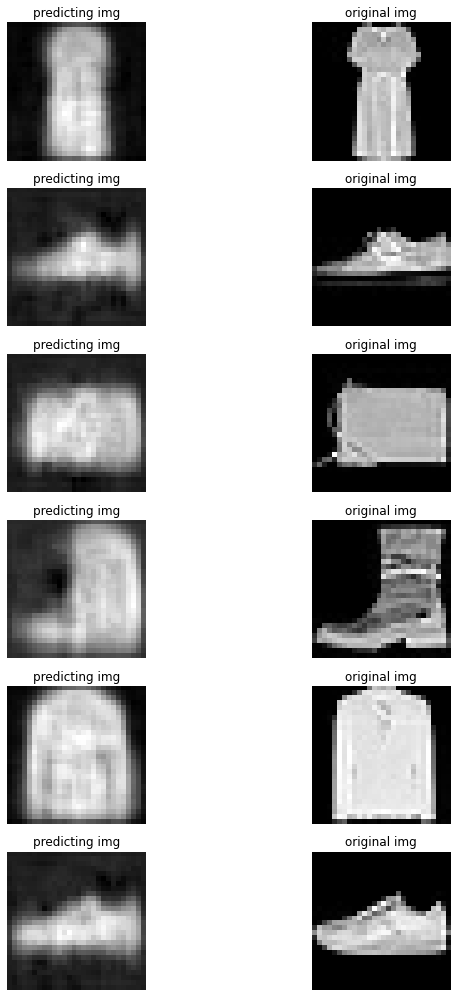

In [36]:
def show_result(result, ori):
    fig = plt.figure(figsize=(10, 30))
    for n in range(6):
        ax = fig.add_subplot(10, 2, n*2 + 1)
        ax.imshow(result[n], 'gray')
        ax.set_title('predicting img')
        ax.axis('off')
        ax = fig.add_subplot(10, 2, n*2 + 2)
        ax.imshow(ori[n], 'gray')
        ax.set_title('original img')
        ax.axis('off')
    
    return

predict_imgs = []
for img in predict_img_batch[0: 25]:
    predict_imgs.append(np.reshape(img, (28,28)))

ori_imgs = []
for ori_img in test_ds.take(1):
    for img in ori_img:
        ori_imgs.append(np.reshape(img, (28, 28)))

show_result(predict_imgs, ori_imgs)